In [ ]:
!python -m jupytools export -nb "12_two_sites_models.ipynb" -o .

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# https://www.kaggle.com/tanlikesmath/rcic-fastai-starter

## Imports 

In [1]:
#export
from collections import OrderedDict
import json
import os
from os.path import dirname, join
from functools import reduce
from pdb import set_trace

import cv2 as cv
import jupytools
import jupytools.syspath
import numpy as np
import pandas as pd
import PIL.Image
import matplotlib.pyplot as plt

from catalyst.utils import get_one_hot
import pretrainedmodels
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from visdom import Visdom

jupytools.syspath.add(join(dirname(os.getcwd()), 'protein_project'))
jupytools.syspath.add('rxrx1-utils')
if jupytools.is_notebook():
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm as tdqm
    
import contextlib, io
with contextlib.redirect_stderr(io.StringIO()):
    from basedir import ROOT, NUM_CLASSES
    from catalyst_visdom import BatchMetricsPlotCallback, EpochMetricsPlotCallback
    from dataset import load_data, build_stats_index, RxRxDataset
    from model.utils import freeze_all, unfreeze_layers
    from visual import rgb, six, show_1, show

In [2]:
#export
torch.set_default_tensor_type(torch.FloatTensor)

## Dataset Reader

In [3]:
#export
from augmentation import JoinChannels, SwapChannels, Resize, ToFloat, Rescale
from augmentation import VerticalFlip, HorizontalFlip, PixelStatsNorm, composer
from augmentation import AugmentedImages

In [4]:
#export
class RxRxImages(Dataset):
    def __init__(self, meta_df, img_dir, site=1, channels=(1, 2, 3, 4, 5, 6), 
                 open_image=PIL.Image.open, n_classes=NUM_CLASSES, train=True):
        
        self.records = meta_df.to_records(index=False)
        self.img_dir = img_dir
        self.site = site
        self.channels = channels
        self.n = len(self.records)
        self.open_image = open_image
        self.n_classes = n_classes
        self.train = train
        
    def _get_image_path(self, index, channel):
        r = self.records[index]
        exp, plate, well = r.experiment, r.plate, r.well
        subdir = 'train' if self.train else 'test'
        path = f'{self.img_dir}/{subdir}/{exp}/Plate{plate}/{well}_s{self.site}_w{channel}.png'
        return path
    
    def __getitem__(self, index):
        paths = [self._get_image_path(index, ch) for ch in self.channels]
        img = np.stack([self.open_image(p) for p in paths])
        img = img.astype(np.float32)
        img = img.transpose(1, 2, 0)
        r = self.records[index]
        if self.train:
            sirna = r.sirna
            target = int(sirna)
            onehot = get_one_hot(target, num_classes=self.n_classes)
            return {'features': img, 'targets': target, 'targets_one_hot': onehot}
        else:
            id_code = r.id_code
            return {'features': img, 'id_code': id_code}
    
    def __len__(self): 
        return self.n

In [5]:
#export
class TwoSiteImages(Dataset):
    def __init__(self, ds1, ds2):
        assert len(ds1) == len(ds2)
        self.ds1, self.ds2 = ds1, ds2
        self.size = len(ds1)
        
    def __getitem__(self, index):
        return {'site1': self.ds1[index], 'site2': self.ds2[index]}
    
    def __len__(self):
        return self.size

## Pipeline Preparation

In [6]:
#export
from split import StratifiedSplit
splitter = StratifiedSplit()
trn_df, val_df = splitter(pd.read_csv(ROOT/'train.csv')) 
tst_df = pd.read_csv(ROOT/'test.csv')

In [7]:
#export
sz = 512
trn_ds = TwoSiteImages(
    ds1=AugmentedImages(ds=RxRxImages(trn_df, ROOT, site=1), tr=composer(resize=sz)),
    ds2=AugmentedImages(ds=RxRxImages(trn_df, ROOT, site=2), tr=composer(resize=sz))
)
val_ds = TwoSiteImages(
    ds1=AugmentedImages(ds=RxRxImages(val_df, ROOT, site=1), tr=composer(resize=sz)),
    ds2=AugmentedImages(ds=RxRxImages(val_df, ROOT, site=2), tr=composer(resize=sz))
)
tst_ds = TwoSiteImages(
    ds1=AugmentedImages(ds=RxRxImages(tst_df, ROOT, site=1, train=False), tr=composer(resize=sz)),
    ds2=AugmentedImages(ds=RxRxImages(tst_df, ROOT, site=2, train=False), tr=composer(resize=sz))
)

In [8]:
#export
def new_loader(ds, bs, drop_last=False, shuffle=True, num_workers=12):
    return DataLoader(ds, batch_size=bs, drop_last=drop_last, 
                      shuffle=shuffle, num_workers=num_workers)

## Model

In [9]:
#export
def resnet(name='resnet18', n_classes=NUM_CLASSES):
    model_fn = pretrainedmodels.__dict__[name]
    model = model_fn(num_classes=1000, pretrained='imagenet')
    new_conv = nn.Conv2d(6, 64, 7, 2, 3, bias=False)
    conv1 = model.conv1.weight
    with torch.no_grad():
        new_conv.weight[:, :] = torch.stack([torch.mean(conv1, 1)]*6, dim=1)
    model.conv1 = new_conv
    return model

In [10]:
#export
from catalyst.contrib.modules import GlobalConcatPool2d
class ResNet_TwoSites(nn.Module):
    def __init__(self, name, n_classes=NUM_CLASSES):
        super().__init__()
        
        base = resnet(name=name, n_classes=n_classes)
        feat_dim = base.last_linear.in_features
        
        self.base = base 
        self.pool = GlobalConcatPool2d()
        self.head = nn.Sequential(
            nn.Linear(feat_dim * 2, feat_dim * 2),
            nn.BatchNorm1d(feat_dim * 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(feat_dim * 2, n_classes)
        )
        
    def forward(self, s1, s2):
        f1 = self.base.features(s1)
        f2 = self.base.features(s2)
        f_merged = self.pool(f1 + f2)
        out = self.head(f_merged.squeeze())
        return out

In [11]:
#export
def freeze_all(model):
    for name, child in model.named_children():
        print('Freezing layer:', name)
        for param in child.parameters():
            param.requires_grad = False

In [12]:
#export
def unfreeze_all(model):
    for name, child in model.named_children():
        print('Un-freezing layer:', name)
        for param in child.parameters():
            param.requires_grad = True

In [13]:
#export
def unfreeze(model, names):
    for name, child in model.named_children():
        if name not in names:
            continue
        print('Un-freezing layer:', name)
        for param in child.parameters():
            param.requires_grad = True

## Train

In [ ]:
#export
model = ResNet_TwoSites()
freeze_all(model)

In [ ]:
#export
from visdom import Visdom

In [ ]:
#export
class RollingLoss:
    def __init__(self, smooth=0.98):
        self.smooth = smooth
        self.prev = 0
    def __call__(self, curr, batch_no):
        a = self.smooth
        avg_loss = a*self.prev + (1 - a)*curr
        debias_loss = avg_loss/(1 - a**batch_no)
        self.prev = avg_loss
        return debias_loss

In [ ]:
#export
def create_loaders(batch_size):
    trn_dl = new_loader(trn_ds, bs=batch_size, shuffle=True)
    val_dl = new_loader(val_ds, bs=batch_size, shuffle=False)
    return OrderedDict([('train', trn_dl), ('valid', val_dl)])

In [ ]:
#export
loss_fn = nn.CrossEntropyLoss()
device = torch.device('cuda:1')

In [ ]:
# sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     torch.optim.AdamW(model.parameters(), lr=3e-4),
#     T_0=1000, T_mult=2, eta_min=1e-5
# )
# lrs = []
# for _ in range(1000 + 2000 + 4000):
#     lr = sched.get_lr()
#     lrs.extend(lr)
#     sched.step()
# plt.plot(lrs)

In [ ]:
#export
epochs = 1000
patience = 500

opt = torch.optim.AdamW(model.parameters(), lr=3e-4)
model = model.to(device)
rolling_loss = dict(train=RollingLoss(), valid=RollingLoss())
steps = dict(train=0, valid=0)

trials = 0
best_metric = -np.inf
history = []
stop = False

vis = Visdom(server='0.0.0.0', port=9090,
             username=os.environ['VISDOM_USERNAME'],
             password=os.environ['VISDOM_PASSWORD'])

loaders = create_loaders(batch_size=40)

sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    opt, T_0=len(loaders['train']), T_mult=2, eta_min=1e-5
)

for epoch in range(1, epochs+1):
    print(f'Epoch [{epoch}/{epochs}]')
    
    if epoch == 1:
        unfreeze_layers(model, ['head'])
    elif epoch == 5:
        unfreeze_all(model)
    
    #curr_lr = opt.param_groups[0]['lr']
    #vis.line(X=[epoch], Y=[curr_lr], win='lr', name='lr', update='append')    
    iteration = dict(epoch=epoch, train_loss=list(), valid_loss=list())
    #print(f"Current learning rate: {opt.param_groups[0]['lr']:.2E}")
    
    for name, loader in loaders.items():
        is_training = name == 'train'
        count = 0
        metric = 0.0
        
        with torch.set_grad_enabled(is_training):
            for batch in loader:
                steps[name] += 1
                opt.zero_grad()

                y = batch['site1']['targets'].to(device)
                
                out = model(
                    batch['site1']['features'].to(device),
                    batch['site2']['features'].to(device)
                )
                
                if is_training:
                    loss = loss_fn(out, y)
                    loss.backward()
                    opt.step()
                    sched.step()
                    
                    curr_lr = opt.param_groups[0]['lr']
                    vis.line(X=[steps[name]], Y=[curr_lr], win='lr', name='lr', update='append')    
                
                avg_loss = rolling_loss[name](loss.item(), steps[name])
                iteration[f'{name}_loss'].append(avg_loss)
                y_pred = out.softmax(dim=1).argmax(dim=1)
                acc = (y_pred == y).float().mean().item()
                metric += acc
                count += len(batch)
                vis.line(X=[steps[name]], Y=[avg_loss], name=f'{name}_loss', 
                         win=f'{name}_loss', update='append', 
                         opts=dict(title=f'Running Loss [{name}]'))
        
        metric /= count
        iteration[f'{name}_acc'] = metric
        vis.line(X=[epoch], Y=[avg_loss], name=f'{name}', win='avg_loss',
                 update='append', opts=dict(title='Average Epoch Loss'))
        vis.line(X=[epoch], Y=[metric], name=f'{name}', win='accuracy', 
                 update='append', opts=dict(title=f'Accuracy'))
        
        last_loss = iteration[f'{name}_loss'][-1]
        
        print(f'{name} metrics: accuracy={metric:2.3%}, loss={last_loss:.4f}')
          
        if is_training:
            # sched.step()
            pass
          
        else:
            # sched.step(metric)
            if metric > best_metric:
                trials = 0
                best_metric = metric
                print('Score improved!')
                torch.save(model.state_dict(), f'two_sites_one_base/train.{epoch}.pth')
            else:
                trials += 1
                if trials >= patience:
                    stop = True
                    break
    
    history.append(iteration)
    
    print('-' * 80)
    
    if stop:
        print(f'Early stopping on epoch: {epoch}')
        break

torch.save(history, 'history.pth')

## Test

In [165]:
device = torch.device('cuda:0')
model = ResNet_TwoSites('resnet50')
freeze_all(model)
model = model.to(device)
state = torch.load('two_way_resnet50_384/train.15.pth', map_location=lambda loc, storage: loc)
model.load_state_dict(state)
_ = model.eval()

Freezing layer: base
Freezing layer: pool
Freezing layer: head


In [17]:
with torch.no_grad():
    test_dl = new_loader(tst_ds, bs=64)
    preds = {}
    for batch in tqdm(test_dl):
        s1 = batch['site1']['features']
        s2 = batch['site2']['features']
        out = model(s1.to(device), s2.to(device))
        y_hat = out.argmax(dim=-1).cpu().numpy()
        preds.update(dict(zip(batch['site1']['id_code'], y_hat.astype(int))))

In [18]:
preds_df = pd.DataFrame([
    {'id_code': id_code, 'sirna': sirna} 
    for id_code, sirna in preds.items()])
preds_df.head(3)

,id_code,sirna
0,HUVEC-21_4_G16,1063
1,HUVEC-19_1_I08,1003
2,HEPG2-08_1_E20,463


In [19]:
len(preds_df)

19897

In [23]:
filename = 'resnet50_two_way_384.csv'
preds_df.to_csv(filename, index=False, columns=['id_code', 'sirna'])
from IPython.display import FileLink
FileLink(filename)

/home/ck/code/tasks/protein/resnet50_two_way_384.csv

## Leak

In [14]:
trn_csv = pd.read_csv(ROOT/'train.csv')
tst_csv = pd.read_csv(ROOT/'test.csv')

### Visualization

In [122]:
n = 25
cols = [f's{i}' for i in range(n)]
data = np.stack([trn_csv.plate.values[trn_csv.sirna == i] for i in range(n)]).transpose()
df = pd.DataFrame(data, columns=cols)
df['sum'] = df.sum(axis=1)
df = df.sort_values(by=['sum'])

In [123]:
def colorize(value):
    color = {
        1: 'color: white; background-color: salmon',
        2: 'color: white; background-color: royalblue', 
        3: 'color: white; background-color: purple', 
        4: 'color: black'
    }.get(value, 'color: black')
    return color

In [124]:
df.T.style.applymap(colorize)

,17,30,28,4,19,13,20,15,21,16,25,22,18,26,27,29,23,24,0,14,12,11,10,9,8,7,6,5,3,2,1,31,32
s0,2,2,2,2,2,2,2,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
s1,3,3,3,3,3,3,3,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
s2,4,4,4,4,4,4,4,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
s3,3,3,3,3,3,3,3,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
s4,1,1,1,1,1,1,1,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
s5,3,3,3,3,3,3,3,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
s6,3,3,3,3,3,3,3,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
s7,4,4,4,4,4,4,4,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
s8,3,3,3,3,3,3,3,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
s9,2,2,2,2,2,2,2,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [125]:
sirna_lines = trn_csv.groupby('sirna').plate.value_counts().rename('counts').reset_index()

In [126]:
sirna_lines.head()

,sirna,plate,counts
0,0,4,22
1,0,2,7
2,0,3,4
3,1,1,22
4,1,3,7


In [127]:
import seaborn as sns

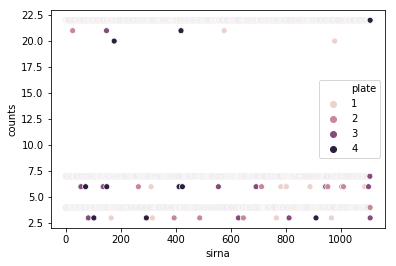

In [128]:
sns.scatterplot(x='sirna', y='counts', hue='plate', estimator=None, data=sirna_lines)

### Exploiting

In [15]:
plate_groups = np.zeros((1108,4), int)
for sirna in range(1108):
    grp = trn_csv.loc[trn_csv.sirna==sirna,:].plate.value_counts().index.values
    assert len(grp) == 3
    plate_groups[sirna,0:3] = grp
    plate_groups[sirna,3] = 10 - grp.sum()

In [16]:
# plate_groups[:10, :]

In [17]:
# co-occurrance
# https://stackoverflow.com/questions/20574257/constructing-a-co-occurrence-matrix-in-python-pandas

In [18]:
sub = pd.read_csv('resnet50_two_way_384.csv')

In [19]:
# all_test_exp = tst_csv.experiment.unique()

# group_plate_probs = np.zeros((len(all_test_exp),4))
# for idx in range(len(all_test_exp)):
#     preds = sub.loc[tst_csv.experiment == all_test_exp[idx],'sirna'].values
#     pp_mult = np.zeros((len(preds),1108))
#     pp_mult[range(len(preds)),preds] = 1
    
#     sub_test = tst_csv.loc[tst_csv.experiment == all_test_exp[idx],:]
#     assert len(pp_mult) == len(sub_test)
    
#     for j in range(4):
#         mask = np.repeat(plate_groups[np.newaxis, :, j], len(pp_mult), axis=0) == \
#                np.repeat(sub_test.plate.values[:, np.newaxis], 1108, axis=1)
        
#         group_plate_probs[idx,j] = np.array(pp_mult)[mask].sum()/len(pp_mult)

In [20]:
all_test_exp = np.array([
    "HEPG2-08", "HEPG2-09", "HEPG2-10", "HEPG2-11",
    "HUVEC-17", "HUVEC-18", "HUVEC-19", "HUVEC-20",
    "HUVEC-21", "HUVEC-22", "HUVEC-23", "HUVEC-24",
    "RPE-08", "RPE-09", "RPE-10", "RPE-11", "U2OS-04",
    "U2OS-05"])

In [21]:
group_plate_probs = np.array([
    [0.226739, 0.257453, 0.190605, 0.325203],
    [0.219314, 0.331227, 0.246390, 0.203069],
    [0.378159, 0.232852, 0.189531, 0.199458],
    [0.371609, 0.238698, 0.194394, 0.195298],
    [0.397112, 0.145307, 0.212996, 0.244585],
    [0.379404, 0.203252, 0.205962, 0.211382],
    [0.184116, 0.175993, 0.471119, 0.168773],
    [0.123646, 0.106498, 0.635379, 0.134477],
    [0.185018, 0.178700, 0.148014, 0.488267],
    [0.507220, 0.149819, 0.194043, 0.148917],
    [0.496815, 0.162875, 0.161965, 0.178344],
    [0.152727, 0.202727, 0.171818, 0.472727],
    [0.190433, 0.333032, 0.206679, 0.269856],
    [0.373080, 0.236676, 0.188799, 0.201445],
    [0.478339, 0.165162, 0.175993, 0.180505],
    [0.361060, 0.194698, 0.237660, 0.206581],
    [0.237365, 0.223827, 0.295126, 0.243682],
    [0.209663, 0.252507, 0.245214, 0.292616]])

In [22]:
pd.DataFrame(group_plate_probs, index=all_test_exp)

,0,1,2,3
HEPG2-08,0.226739,0.257453,0.190605,0.325203
HEPG2-09,0.219314,0.331227,0.246390,0.203069
HEPG2-10,0.378159,0.232852,0.189531,0.199458
HEPG2-11,0.371609,0.238698,0.194394,0.195298
HUVEC-17,0.397112,0.145307,0.212996,0.244585
HUVEC-18,0.379404,0.203252,0.205962,0.211382
HUVEC-19,0.184116,0.175993,0.471119,0.168773
HUVEC-20,0.123646,0.106498,0.635379,0.134477
HUVEC-21,0.185018,0.178700,0.148014,0.488267
HUVEC-22,0.507220,0.149819,0.194043,0.148917


In [23]:
exp_to_group = group_plate_probs.argmax(1)
print(exp_to_group)

[3 1 0 0 0 0 2 2 3 0 0 3 1 0 0 0 2 3]


In [24]:
device = torch.device('cuda:0')
model = ResNet_TwoSites('resnet50')
freeze_all(model)

model = model.to(device)
state = torch.load('two_way_resnet50_384/train.15.pth', map_location=lambda loc, storage: loc)
model.load_state_dict(state)
_ = model.eval()

with torch.no_grad():
    test_dl = new_loader(tst_ds, bs=64, shuffle=False)
    preds = []
    for batch in tqdm(test_dl):
        s1 = batch['site1']['features']
        s2 = batch['site2']['features']
        out = model(s1.to(device), s2.to(device))
        probs = out.softmax(dim=-1).cpu().numpy()
        preds.append(probs)

Freezing layer: base
Freezing layer: pool
Freezing layer: head


In [25]:
stacked = np.row_stack(preds).squeeze()

In [26]:
sub = pd.read_csv('resnet50_two_way_384.csv')

In [27]:
def select_plate_group(pp_mult, idx):
    sub_test = tst_csv.loc[tst_csv.experiment == all_test_exp[idx],:]
    assert len(pp_mult) == len(sub_test)
    mask = np.repeat(plate_groups[np.newaxis, :, exp_to_group[idx]], len(pp_mult), axis=0) != \
           np.repeat(sub_test.plate.values[:, np.newaxis], 1108, axis=1)
    pp_mult[mask] = 0
    return pp_mult

In [28]:
sub = sub.set_index('id_code')

In [29]:
for idx in range(len(all_test_exp)):
    indexes = tst_csv.experiment == all_test_exp[idx]
    preds = stacked[indexes, :].copy()
    preds = select_plate_group(preds, idx)
    sub.loc[tst_csv.id_code[indexes], 'sirna'] = preds.argmax(1)

In [30]:
sub = sub.reset_index()

In [31]:
(sub.sirna == pd.read_csv('resnet50_two_way_384.csv').sirna).mean()

0.11795748102729055

In [32]:
from IPython.display import FileLink
sub.to_csv('leak.csv', index=False, columns=['id_code', 'sirna'])
FileLink('leak.csv')

/home/ck/code/tasks/protein/leak.csv